In [1]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow
import pandas as pd
from glob import glob
print(cv2.__version__)

4.1.2


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Yolo 로드 (weight, cfg, obj.names 경로 설정)
import cv2
net = cv2.dnn.readNet('/content/drive/MyDrive/최종프로젝트/자료/final/yolov3_training_5classes.weights','/content/drive/MyDrive/최종프로젝트/자료/final/yolov3_testing.cfg')
classes = []
with open("/content/drive/MyDrive/최종프로젝트/자료/final/obj.names", "r") as f:
    classes = [line.strip() for line in f.readlines()]
layer_names = net.getLayerNames()
output_layers = [layer_names[i[0] - 1] for i in net.getUnconnectedOutLayers()]
colors = np.random.uniform(0, 255, size=(len(classes), 3))

In [8]:
# 이미지 캡쳐 함수
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='/content/drive/MyDrive/photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

In [5]:
# 객체 인식 및 음성 출력 함수
def yoloimg(imgfile):
    # 이미지 가져오기
    img = cv2.imread(imgfile)
    # img = cv2.resize(img, None, fx=0.4, fy=0.4)
    height, width, channels = img.shape
    # Detecting objects
    blob = cv2.dnn.blobFromImage(img, 0.00392, (416, 416), (0, 0, 0), True, crop=False)
    net.setInput(blob)
    outs = net.forward(output_layers)
    # 정보를 화면에 표시
    class_ids = []
    confidences = []
    boxes = []
    for out in outs:
        for detection in out:
            scores = detection[5:]
            class_id = np.argmax(scores)
            confidence = scores[class_id]
            if confidence > 0.5:
                # Object detected
                center_x = int(detection[0] * width)
                center_y = int(detection[1] * height)
                w = int(detection[2] * width)
                h = int(detection[3] * height)
                # 좌표
                x = int(center_x - w / 2)
                y = int(center_y - h / 2)
                boxes.append([x, y, w, h])
                confidences.append(float(confidence))
                class_ids.append(class_id)
    indexes = cv2.dnn.NMSBoxes(boxes, confidences, 0.5, 0.4)
    font = cv2.FONT_HERSHEY_PLAIN

    # 객체 인식 이미지 출력
    font = cv2.FONT_HERSHEY_PLAIN
    for i in range(len(boxes)):
        # if i in indexes:
            x, y, w, h = boxes[i]
            label = str(classes[class_ids[i]])
            color = colors[i]
            # cv2.rectangle(img, (x, y), (x + w, y + h), color, 2)
            cv2.rectangle(img, (x, y), (x + w, y + h), color, 2)
            cv2.putText(img, label, (x, y + 30), font, 3, color, 3)

    from google.colab.patches import cv2_imshow
    cv2_imshow(img)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

    # 각 Class의 개수를 센 후 df에 넣어줌.
    countid = []
    for i in range(5):
        countid.append(class_ids.count(i))
    jpgname = imgfile.split('/')[-1].split('.')[0]
    df = pd.DataFrame({'jpgname':jpgname, 'Person':countid[0], 'Vest':countid[1], 'Helmet' : countid[2], 'NoHelmet' : countid[3], 'NoVest':countid[4]},  index=[0])

    # 음성 출력
    from IPython.display import Audio
    if df.Person[0] >= 2:
        return(Audio("/content/drive/MyDrive/최종프로젝트/코드/음성출력/한명만_서주세요.mp3", autoplay=True))
    elif df.Person[0] == 1 and df.Helmet[0] == 1 and df.Vest[0]==1:
        return(Audio("/content/drive/MyDrive/최종프로젝트/코드/음성출력/정상입니다.mp3", autoplay=True))
    elif df.Person[0] == 1 and df.Helmet[0] == 0 and df.Vest[0]==1:
        return(Audio("/content/drive/MyDrive/최종프로젝트/코드/음성출력/헬멧_미착용입니다.mp3", autoplay=True))
    elif df.Person[0] == 1 and df.Helmet[0] == 1 and df.Vest[0] == 0:
        return(Audio("/content/drive/MyDrive/최종프로젝트/코드/음성출력/조끼_미착용입니다.mp3", autoplay=True))
    else:
        return(Audio("/content/drive/MyDrive/최종프로젝트/코드/음성출력/다시_서주세요.mp3", autoplay=True))

<IPython.core.display.Javascript object>

Saved to /content/drive/MyDrive/photo.jpg


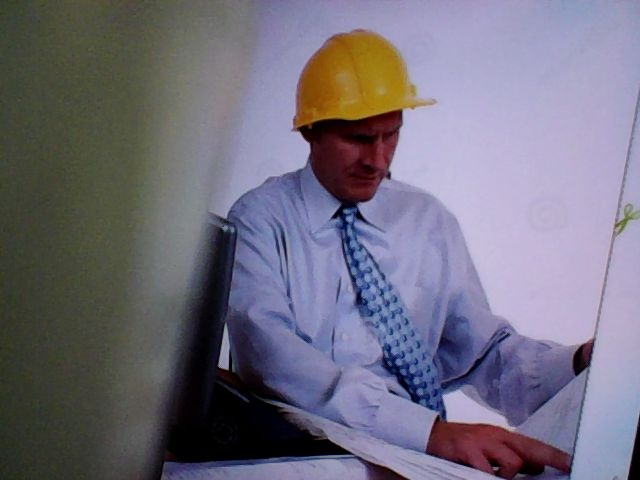

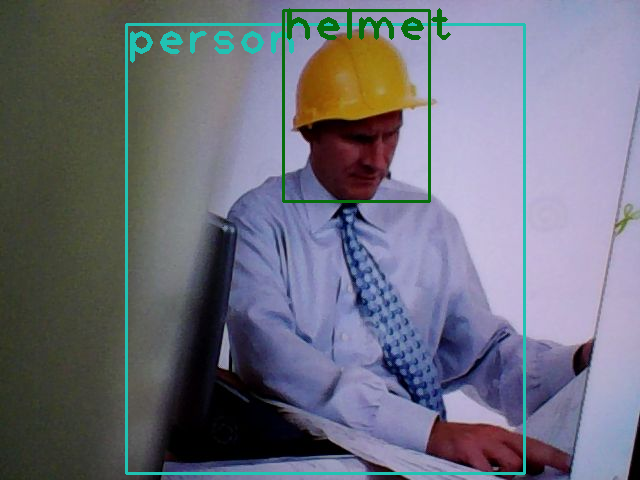

In [12]:
from IPython.display import Image
try:
  filename = take_photo()
  print('Saved to {}'.format(filename))
  
  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

img = '/content/drive/MyDrive/photo.jpg'
yoloimg(img)